In [44]:
import gym
import gym_classics
import warnings
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [55]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, EPSILON):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

In [79]:
def sarsa(Q, params):
    state = START
    action = choose_action(state, Q, params["epsilon"])
    tot_reward = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q, params["epsilon"])
        tot_reward += reward
        target = Q[next_state[0], next_state[1], next_action] * params["gamma"]
        td_error = reward + target - Q[state[0], state[1], action]
        Q[state[0], state[1], action] += params["alpha"] * td_error
        state = next_state
        action = next_action
    return tot_reward

In [80]:
params = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
}

RUNS = 50
EPISODES = 500
reward_sarsa = np.zeros(EPISODES)
for r in tqdm(range(RUNS)):
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(EPISODES):
        reward_sarsa[i] += sarsa(q_sarsa, params)
reward_sarsa /= RUNS

100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


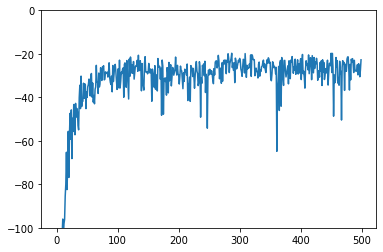

In [81]:
plt.plot(reward_sarsa)
plt.ylim([-100, 0])
plt.show()

In [84]:
def qlearning(Q, params):
    tot_reward = 0
    state = START
    while state != GOAL:
        action = choose_action(state, Q, params["epsilon"])
        next_state, reward = step(state, action)
        target = params["gamma"] * np.max(Q[next_state[0], next_state[1], :])
        td_error = reward + target -  Q[state[0], state[1], action]
        Q[state[0], state[1], action] += params["alpha"] * td_error

        state = next_state
        tot_reward += reward
        
    return tot_reward

In [85]:
params = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
}

RUNS = 50
EPISODES = 500
reward_qlearning = np.zeros(EPISODES)
for r in tqdm(range(RUNS)):
    q_qlearning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(EPISODES):
        reward_qlearning[i] += qlearning(q_qlearning, params)
reward_qlearning /= RUNS

100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


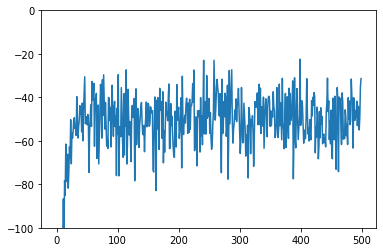

In [88]:
plt.plot(reward_qlearning)
plt.ylim([-100, 0])
plt.show()

In [105]:
def expected_sarsa(Q, params):
    state = START
    action = choose_action(state, Q, params["epsilon"])
    tot_reward = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q, params["epsilon"])
        tot_reward += reward
        target = 0.0
        Q_next = Q[next_state[0], next_state[1], :]
        best_actions = np.argwhere(Q_next == np.max(Q_next))
        for a in ACTIONS:
            if a in best_actions:
                target += (1 - params["epsilon"]) / len(best_actions) * Q_next[a]
            target += params["epsilon"] / len(ACTIONS) * Q_next[a]
        target *= params["gamma"]
        Q[state[0], state[1], action] += params["alpha"] * (
                reward + target - Q[state[0], state[1], action])
        state = next_state
        action = next_action
    return tot_reward

In [106]:
params = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
}

RUNS = 10
EPISODES = 500
reward_expsarsa = np.zeros(EPISODES)
for r in tqdm(range(RUNS)):
    q_expsarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(EPISODES):
        reward_expsarsa[i] += expected_sarsa(q_expsarsa, params)
reward_expsarsa /= RUNS

100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


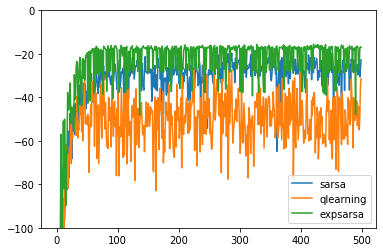

In [107]:
plt.plot(reward_sarsa, label='sarsa')
plt.plot(reward_qlearning, label='qlearning')
plt.plot(reward_expsarsa, label='expsarsa')
plt.ylim([-100, 0])
plt.legend(loc='lower right')
plt.show()